In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
# read excel and save it as data frame
df = pd.read_excel("./data/social_data.xlsx")

## Preliminary EDA

In [3]:
# show first 5 rows of dataframe
df.head()

,Published Date,Account,Account Type,Campaign Name,Total Impressions,Total Engagements,Media Type
0,2023-03-31 19:55:43.192,CSGO,TWITTER,N/A,0,0,Text
1,2023-03-31 19:49:35.243,CSGO,TWITTER,N/A,0,0,Text
2,2023-03-31 19:49:33.535,CSGO,TWITTER,N/A,0,0,Text
3,2023-03-31 19:49:31.583,CSGO,TWITTER,N/A,0,0,Text
4,2023-03-31 19:43:42.590,CSGO,TWITTER,Community Engagement,9517,1215,Video


In [4]:
# make sure data types of columns are correct
df.dtypes

Published Date       datetime64[ns]
Account                      object
Account Type                 object
Campaign Name                object
Total Impressions             int64
Total Engagements             int64
Media Type                   object
dtype: object

In [5]:
# find range of data
df.describe()

,Total Impressions,Total Engagements
count,3479.000000,3479.000000
mean,10972.453579,947.390629
std,29577.108063,3468.628038
min,0.000000,0.000000
25%,167.000000,0.000000
50%,1884.000000,39.000000
75%,12467.000000,276.500000
max,753227.000000,95062.000000


## Number 1: What is the typical engagement rate we can expect? What’s the likelihood that we can achieve a 15% engagement rate?

To answer the first part of the question, we can find the mean of the engagement rate of each post. To be clear, we are defining engagement rate as the engagement of a post divided by the impression of the same post.

In [6]:
engagement_rate = (df["Total Engagements"] / df["Total Impressions"]) * 100

In [7]:
engagement_rate = engagement_rate.fillna(0)

In [8]:
engagement_rate.describe()

count     3479.000000
mean        31.833090
std       1593.821839
min          0.000000
25%          0.000000
50%          2.041949
75%          5.004670
max      94000.000000
dtype: float64

As shown above, the mean engagement rate is around 31.83%. Thus, the typical engagement rate we can expect is 31.83%

To answer the second part of the question, we can standardize the engagement rate. By the central limit theorem, the cumulative distribution function (CDF) of Z<sub>n</sub> converges to the standard normal CDF. We can calculate the probability of achieving a 15% engagement rate using the mean and standard deviation found above.

In [9]:
from scipy.stats import norm
1 - norm.cdf(15, engagement_rate.mean(), engagement_rate.std())

0.5042133357377332

Thus, the likelihood we can achieve a 15% engagement rate is around 50.42%

## Number 2: Does day of the week and time of posting affect engagement rates?

To answer this question, we want to create weekday and hour variables in our data frame. In this question, we separate "time" by every hour.

In [10]:
# create column that contains the weekday the post was published
df['Weekday'] = df["Published Date"].apply(lambda x: x.strftime('%A'))

In [11]:
# order the weekdays from Monday-Sunday
df['Weekday'] = pd.Categorical(df['Weekday'], categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
    ordered=True)

In [12]:
# create column that contains the hour the post was published
df["Hour"] = df["Published Date"].apply(lambda x: x.hour)

In [13]:
df.head()

,Published Date,Account,Account Type,Campaign Name,Total Impressions,Total Engagements,Media Type,Weekday,Hour
0,2023-03-31 19:55:43.192,CSGO,TWITTER,N/A,0,0,Text,Friday,19
1,2023-03-31 19:49:35.243,CSGO,TWITTER,N/A,0,0,Text,Friday,19
2,2023-03-31 19:49:33.535,CSGO,TWITTER,N/A,0,0,Text,Friday,19
3,2023-03-31 19:49:31.583,CSGO,TWITTER,N/A,0,0,Text,Friday,19
4,2023-03-31 19:43:42.590,CSGO,TWITTER,Community Engagement,9517,1215,Video,Friday,19


Just because I am curious, let's visualize the general trend of engagements and impressions of all posts with a line graph. While it may not be as useful in answering this particular question, it helps contextualize the impressions and engagements throughout January to April.

[Text(0.5, 1.0, 'Impressions From January to April 2023'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Number of Impressions')]

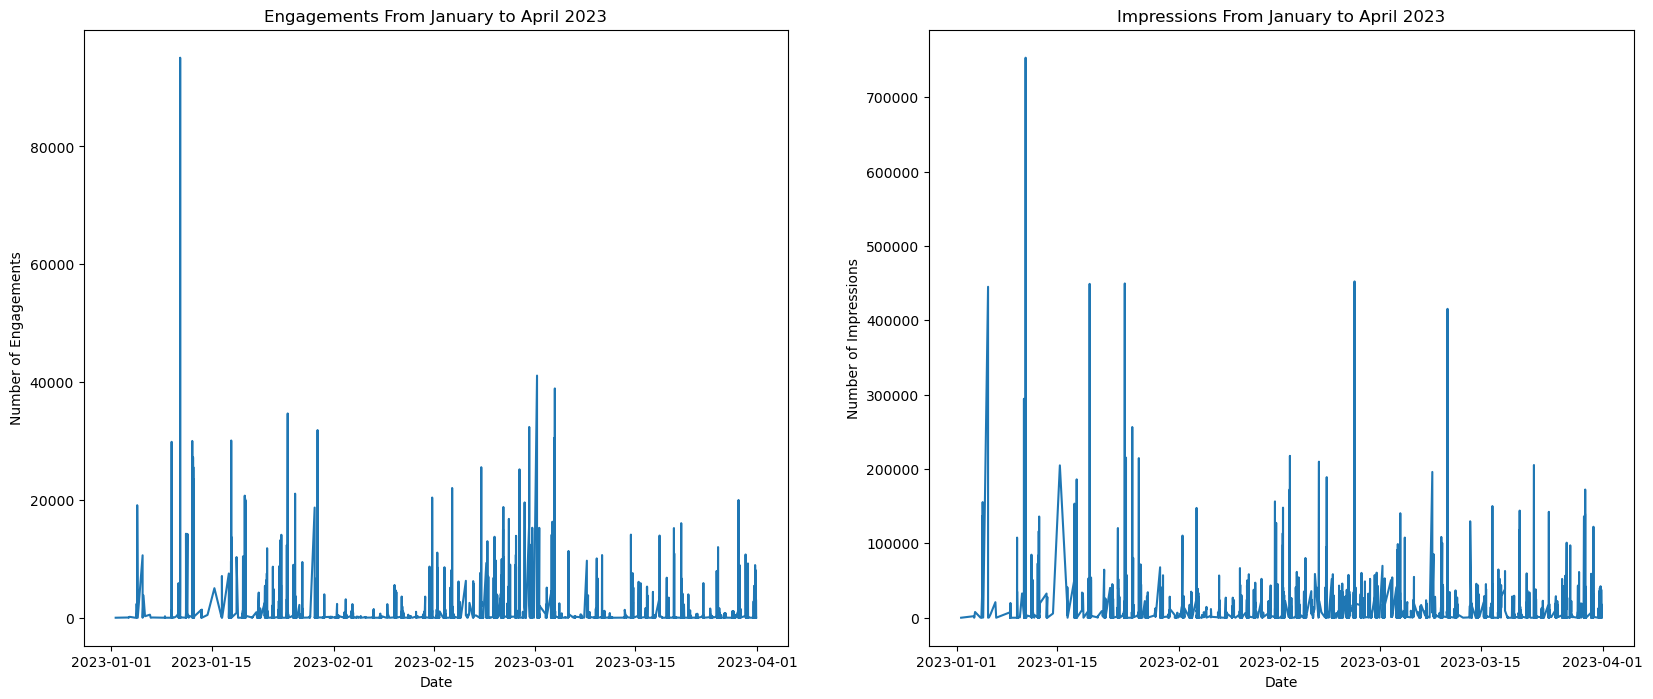

In [14]:
# use line plots to visualize general trend of engagements and impressions from posts
fig, ax = plt.subplots(1, 2, figsize = (20, 8))


ax0 = ax[0]
ax1 = ax[1]

ax0.plot(df["Published Date"], df["Total Engagements"])
ax0.set(title = "Engagements From January to April 2023",
        xlabel = "Date",
        ylabel = "Number of Engagements")

ax1.plot(df["Published Date"], df["Total Impressions"])
ax1.set(title = "Impressions From January to April 2023",
        xlabel = "Date",
        ylabel = "Number of Impressions")

It is clear that engagements and impressions can be quite sporadic. We can get a better look at engagements and impressions in relation to time by looking at weekdays and hours.

In order to do this, we should create a couple of helper functions (which will help us in the rest of the problems as well).

In [15]:
def create_total_mean_df(df, column_to_gb, hour = True):
    """
    Groups a data frame by a column and returns the grouped data frame 
    containing the summed or averaged engagement and impressions grouped 
    by that column. Also gives the engagement rate as a series.
    
    : param df: data frame we are working with
    : param column to gb: column to be grouped by
    : param hour: deals with fringe case when we work with the hour column; when hour = True, we are not grouping by the 
                    the hour column and we will drop the hour column to make the returned data frames look nicer. If
                    hour = False, then we are working with the hour column and we should not drop the hour column
                    
    : return: a tuple of two data frames and a series
    :            df_total: the data frame grouped by the intended column with summed engagement and impression values
    :            df_mean: the data frame grouped by the intended column with mean engagement and impression values
    :            engagement_rate: a series containing the engagement rate (total engagements / impressions)
    """
    if hour == True:
        df_total = df.groupby(column_to_gb).sum().drop(columns = ["Hour"])
        df_mean = df.groupby(column_to_gb).mean().drop(columns = ["Hour"])
        engagement_rate = (df_total["Total Engagements"] / df_total["Total Impressions"]) * 100
    
    else:
        df_total = df.groupby(column_to_gb).sum()
        df_mean = df.groupby(column_to_gb).mean()
        engagement_rate = (df_total["Total Engagements"] / df_total["Total Impressions"]) * 100
    
    return df_total, df_mean, engagement_rate

In [16]:
# create function to make a figure plotting the engagements and impressions
def create_imp_eng_fig(total_df, mean_df, xlabel = "X Axis", figsize = (20, 20)): 
    """
    Plots bar graphs for the data frames from the create_total_mean_df function.
    Intended to show engagements and impressions from various groups.
    
    : param total_df: data frame that contains the summed engagement and impressions
    : param mean_df: data frame that contains the averaged engagement and impressions
    : xlabel: a string of an intended x-axis label
    : figsize: figure size
    
    return: a figure of four plots; one bar graph plots total engagements,
                                    one bar graph plots mean engagements,
                                    one bar graph plots total impressions,
                                    one bar graph plots mean impressions
    """
    
    
    fig = plt.figure(figsize = figsize)
    gs = GridSpec(nrows = 2, ncols = 2)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    # plot total engagements
    total_df["Total Engagements"].plot.bar(ax = ax0)
    ax0.set_xlabel(xlabel)
    ax0.set_ylabel("Total Engagements")
    ax0.set_title("Total Engagements Per " + xlabel)
    
    # plot mean engagements
    mean_df["Total Engagements"].plot.bar(ax = ax1)
    ax1.set_xlabel(xlabel)
    ax2.set_ylabel("Mean Engagements")
    ax2.set_title("Mean Engagements Per " + xlabel)
    
    # plot total impressions
    total_df["Total Impressions"].plot.bar(ax = ax2)
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel("Total Impressions")
    ax2.set_title("Total Impressions Per " + xlabel)
    
    mean_df["Total Impressions"].plot.bar(ax = ax3)
    ax3.set_xlabel(xlabel)
    ax3.set_ylabel("Mean Impressions")
    ax3.set_title("Mean Impressions Per " + xlabel)

### Does the day of week affect engagement rates?

In [17]:
# create weekday data frames to see if day of week affects engagement rates
weekday_engagements_total, weekday_engagements_mean, weekday_engagement_rate = create_total_mean_df(df, "Weekday")

C:\Users\Florence.000\AppData\Local\Temp\ipykernel_796\930955517.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_total = df.groupby(column_to_gb).sum().drop(columns = ["Hour"])
C:\Users\Florence.000\AppData\Local\Temp\ipykernel_796\930955517.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df.groupby(column_to_gb).mean().drop(columns = ["Hour"])


In [18]:
weekday_engagements_total

,Total Impressions,Total Engagements
Weekday,,
Monday,2476029,166279
Tuesday,7197026,731487
Wednesday,5736454,448516
Thursday,8522704,764920
Friday,7481113,642596
Saturday,3028493,146694
Sunday,3731347,395480


In [19]:
weekday_engagements_mean

,Total Impressions,Total Engagements
Weekday,,
Monday,10581.320513,710.594017
Tuesday,12828.923351,1303.898396
Wednesday,9976.441739,780.027826
Thursday,12071.818697,1083.456091
Friday,10566.543785,907.621469
Saturday,9493.708464,459.855799
Sunday,9923.795213,1051.808511


In [20]:
weekday_engagement_rate

Weekday
Monday        6.715551
Tuesday      10.163740
Wednesday     7.818698
Thursday      8.975086
Friday        8.589578
Saturday      4.843795
Sunday       10.598853
dtype: float64

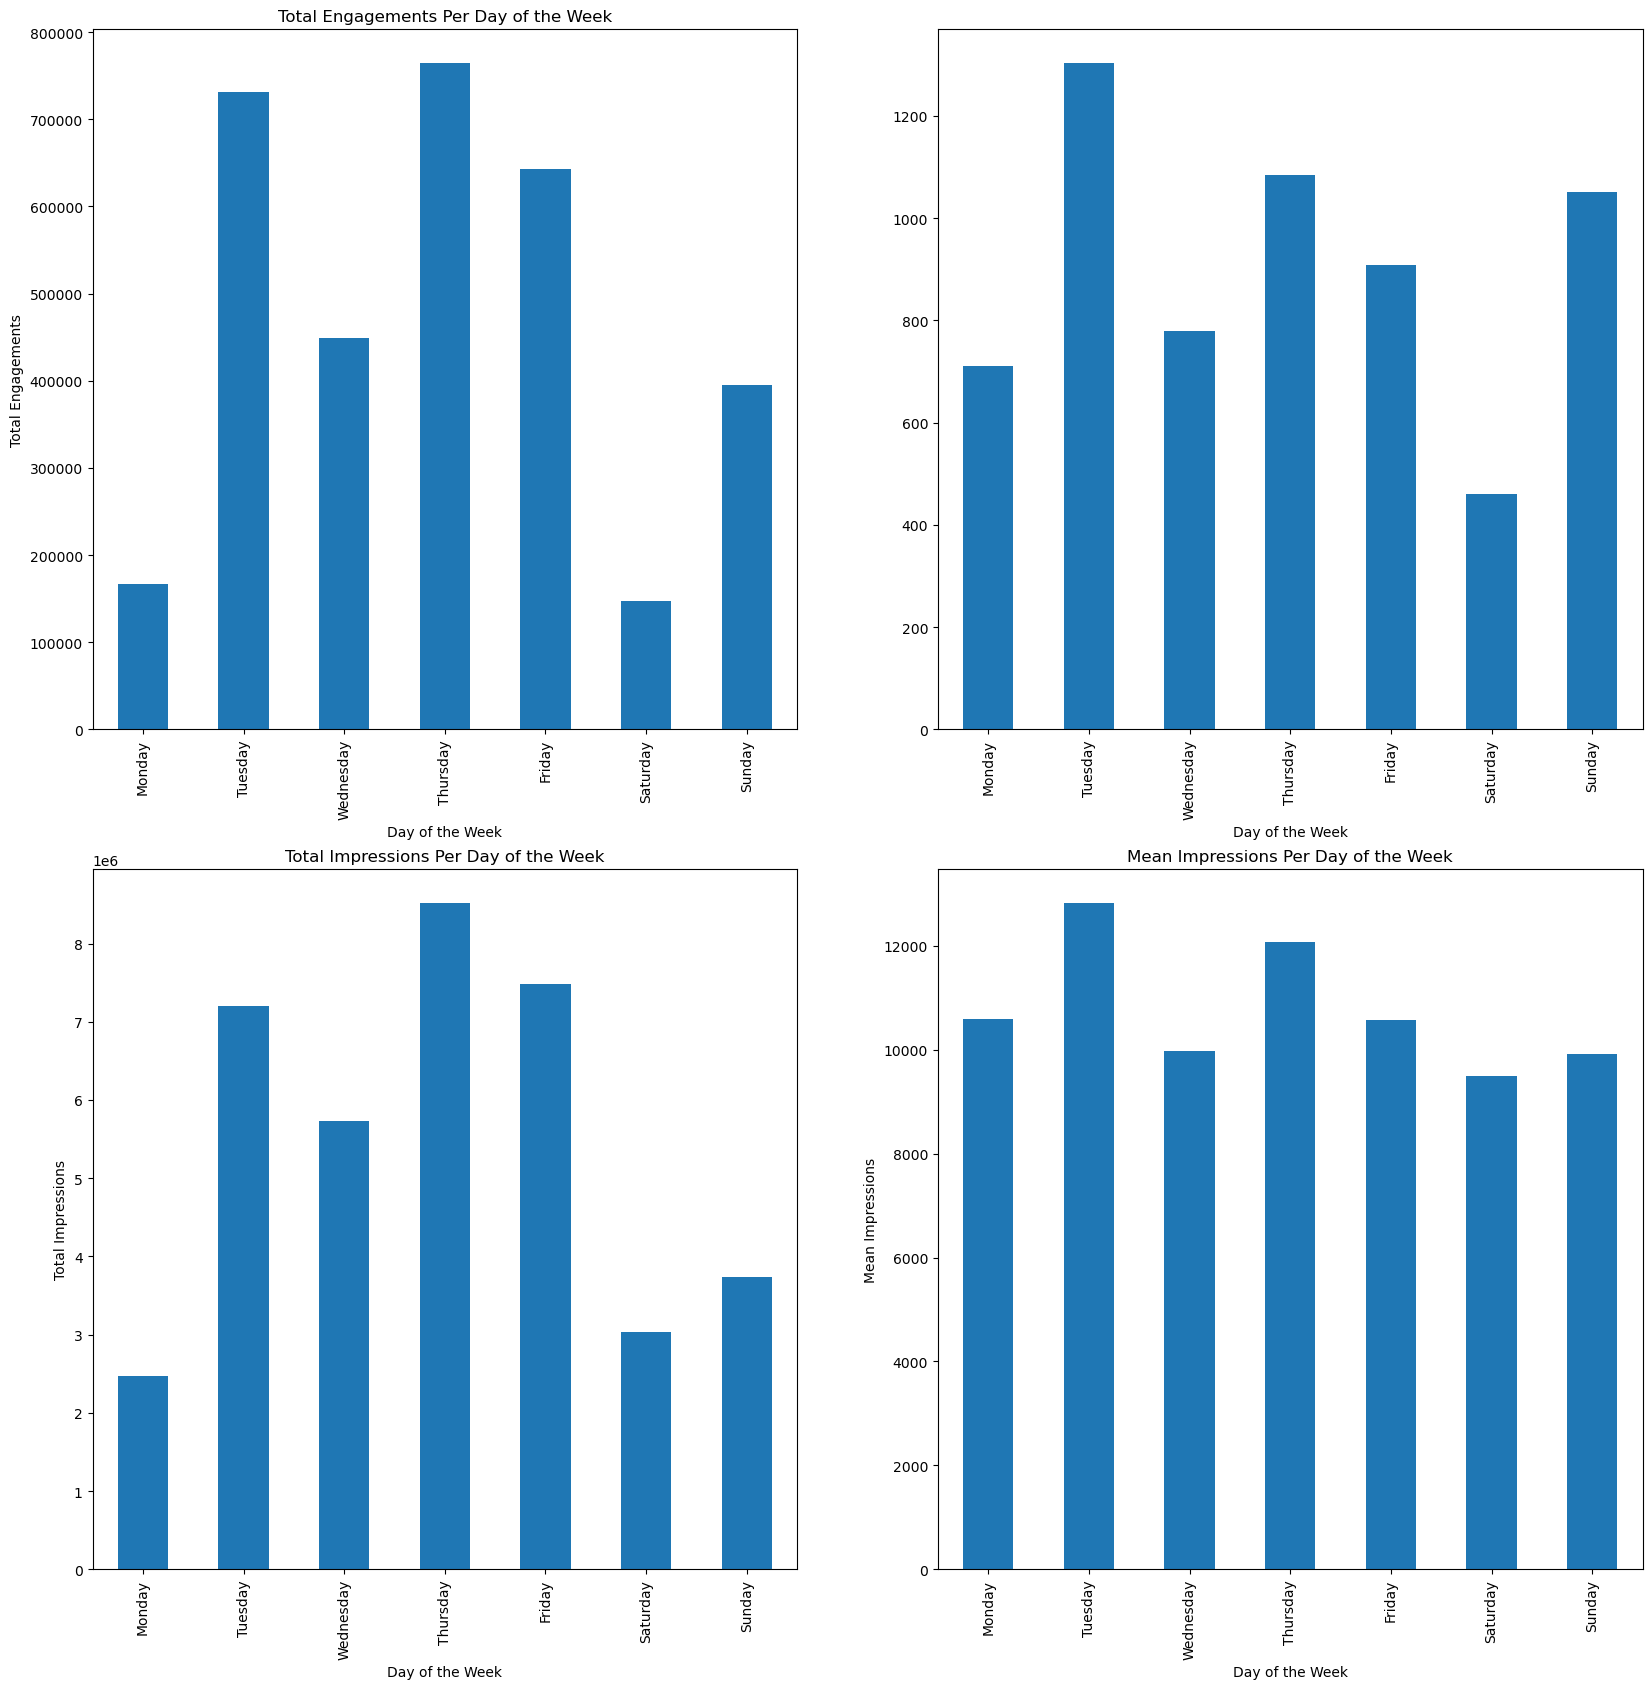

In [21]:
# plot bar graphs to see if day of week affects engagement rates
create_imp_eng_fig(weekday_engagements_total, weekday_engagements_mean, "Day of the Week")

The above bar graphs show the day of week in relation to total engagements and impressions. Below is a quick explanation of each plot:

- Top Left Bar Plot: shows the total engagements for each weekday. Saturday and Monday have the least number of total engagements whereas Thursday seems to have the most engagements
- Top Right Bar Plot: shows the average engagements for each weekday. Now that we have taken into account the number of posts, it seems as though Tuesday is the best performing weekday. Thursday is the second best performing weekday, with Sunday being close.
- Bottom Left Bar Plot: shows the total impressions for each weekday. Monday and the weekends show the least amount of total impressions whereas Thursday shows the most.
- Bottom Right Bar Plot: shows the average impressions for each weekday. With the number of posts being taken into account, we see less variance between weekdays. Nonetheless, it seems as though the best day to have the most people see a post is on Tuesday, since it has the highest average impressions.

With engagement and impressions graphed in relation to day of the week, we should look at the engagement rate and answer the question: does day of week affect engagement rate?

[Text(0.5, 0, 'Day of the Week'),
 Text(0, 0.5, 'Engagement Rate (%)'),
 Text(0.5, 1.0, 'Engagement Ratio Per Day of Week')]

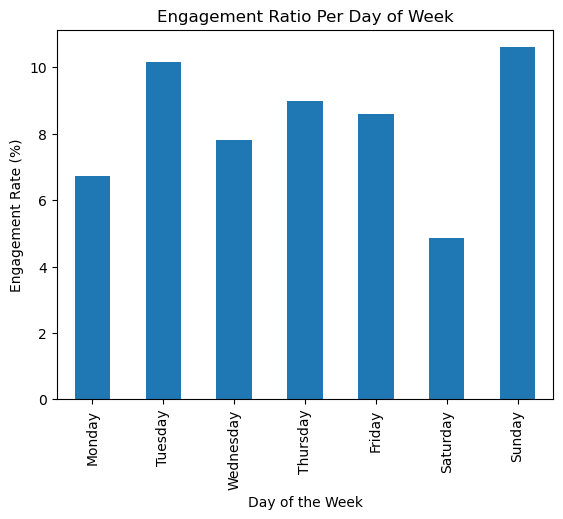

In [22]:
# plot engagement ratio
weekday_engagement_rate.plot.bar().set(xlabel = "Day of the Week",
                                       ylabel = "Engagement Rate (%)",
                                       title = "Engagement Ratio Per Day of Week")

As seen in the graph above, engagement ratio seems to be affected by day of the week. I say this because I see variability between all days. The fact that Tuesday and Saturday have such a stark difference between each other than the difference between other days leads me to believe that the engagement ratio is affected by the day of the week.

However, I would not be surprised to see the opposite.The highest change seems to be around 6%, (Thursday and Saturday), which is not that big of a difference in general.

Whilst graphs can be helpful in looking at general trends of the data, it is as helpful as concrete evidence and statistical tests. We will perform ANOVA and a pairwise t-test to answer the question: does day of week affect engagement rates?

For ANOVA, our null and alternate hypotheses are:
- H<sub>0</sub> = Tuesday<sub>mean</sub> = Wednesday<sub>mean</sub> = Thursday<sub>mean</sub> = Friday<sub>mean</sub> = Saturday<sub>mean</sub> = Sunday<sub>mean</sub>
- H<sub>a</sub> = At least one of the means is different

In [23]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [24]:
def do_anova(df, col):
    """
    Performs anova with dummy variables on one column. Tests variance between categories in a column.
    : param df: data frame to perform anova on
    : param dummy_col: column to create dummy variables with
    : hour: deals with fringe case where we work with the hour column
            if hour = False, we are not working with the hour column
            if hour = True, we are working with the hour column
    
    : return: a tuple of summaries
                model_summary: linear model summary
                aov_table: anova table summary
    """
    
    new_df = pd.concat([(df[col]), engagement_rate.rename("Engagement_Rate")] , axis = 1)
    model = ols(f'Engagement_Rate ~ {col}', data = new_df).fit()
    model_summary = model.summary()
    anova = sm.stats.anova_lm(model, typ=2)
    anova
    
    return model_summary, anova

In [25]:
weekday_lm, weekday_anova = do_anova(df, "Weekday")

In [26]:
weekday_lm

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Engagement_Rate   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6447
Date:                Mon, 29 May 2023   Prob (F-statistic):              0.694
Time:                        15:18:31   Log-Likelihood:                -30588.
No. Observations:                3479   AIC:                         6.119e+04
Df Residuals:                    3472   BIC:                         6.123e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.5907    104.223      0.034      0.973    -200.755     207.936
Weekday[T.Tuesday]       1.4652    124.070      0.012      0.991    -241.792     244.723
Weekday[T.Wednesday]    -0.2679    123.625     -0.002      0.998    -242.652     242.117
Weekday[T.Thursday]      4.3404    120.261      0.036      0.971    -231.450     240.131
Weekday[T.Friday]      133.3668    120.219      1.109      0.267    -102.341     369.074
Weekday[T.Saturday]     -0.5221    137.225     -0.004      0.997    -269.571     268.527
Weekday[T.Sunday]        0.7071    132.750      0.005      0.996    -259.570     260.984
==============================================================================
Omnibus:                    11681.043   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1741630159.760
Skew:                          58.833   Prob(JB):                         0.00
Kurtosis:                    3467.224   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notice how none of the p-values for each intercept are below 0.05. This is a not a statisitcally significant result. Thus, we  fail to reject the null hypothesis (all sample means are the same).

In [27]:
weekday_anova

,sum_sq,df,F,PR(>F)
Weekday,9.832839e+06,6.0,0.644736,0.694468
Residual,8.825219e+09,3472.0,NaN,NaN


Our f-statistic is around 0.64, which is below 1. This f-statistic tells us the variance of the data. The higher the f-statistic, the more varied the data is between each other. Since the f-statistic is low, we have reason to believe that the variance between weekdays is quite low.

Since the variance between weekdays in affecting engagement rates is low, we can infer that Monday is not very different from Tuesday and Tuesday is not very different from Wednesday (and so on). As such, there is a reason to conclude that weekdays do not greatly affect engagement rates.

###  Does the hour of posting affect engagement rates?

In [28]:
df.Hour.unique()

array([19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7, 23, 21, 20, 22,
        6,  5,  4,  3,  0,  2], dtype=int64)

In [29]:
# create hour data frames to see if hour affects engagement rates
hour_engagements_total, hour_engagements_mean, hour_engagement_rate = create_total_mean_df(df, "Hour", hour = False)

C:\Users\Florence.000\AppData\Local\Temp\ipykernel_796\930955517.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_total = df.groupby(column_to_gb).sum()
C:\Users\Florence.000\AppData\Local\Temp\ipykernel_796\930955517.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df.groupby(column_to_gb).mean()


I am a bit more suspicious about AM posts. Since it is less likely for posts to come out at the AMs (which is natural, since most people would be asleep our the social media team would not be working), I suspect there to be an insufficient amount of data for specific hours

In [30]:
# suspicious about AM posts; make sure we have sufficient amount of data (posts) by grouping and using count function
df.groupby("Hour").count().iloc[:,0]

Hour
0       1
2       1
3       6
4       9
5      31
6      78
7     128
8     172
9     384
10    265
11    372
12    311
13    332
14    357
15    326
16    299
17    188
18    107
19     50
20     26
21     10
22      6
23     20
Name: Published Date, dtype: int64

As shown above, 12AM amd 2AM only have 1 post. Furthermore, the social media team has not posted between 1AM and 2AM at all. Contrast this 1 post to the 357 posts between 2 and 3PM and we can see why this could be a problem. I do not want to skew already cleaned data, so I will choose to keep it in. However, it is important to keep these low number of posts in mind when analyzing the data.

In [31]:
hour_engagements_total

,Total Impressions,Total Engagements
Hour,,
0,0,0
2,32613,274
3,66113,5114
4,46270,4135
5,342095,89914
6,724663,58521
7,1059382,151929
8,1901692,198343
9,5292903,467383


In [32]:
hour_engagements_mean

,Total Impressions,Total Engagements
Hour,,
0,0.000000,0.000000
2,32613.000000,274.000000
3,11018.833333,852.333333
4,5141.111111,459.444444
5,11035.322581,2900.451613
6,9290.551282,750.269231
7,8276.421875,1186.945312
8,11056.348837,1153.156977
9,13783.601562,1217.143229


Before plotting engagement rates, I, again, want to see general trends of engagements and impressions in relation to each hour of the day.

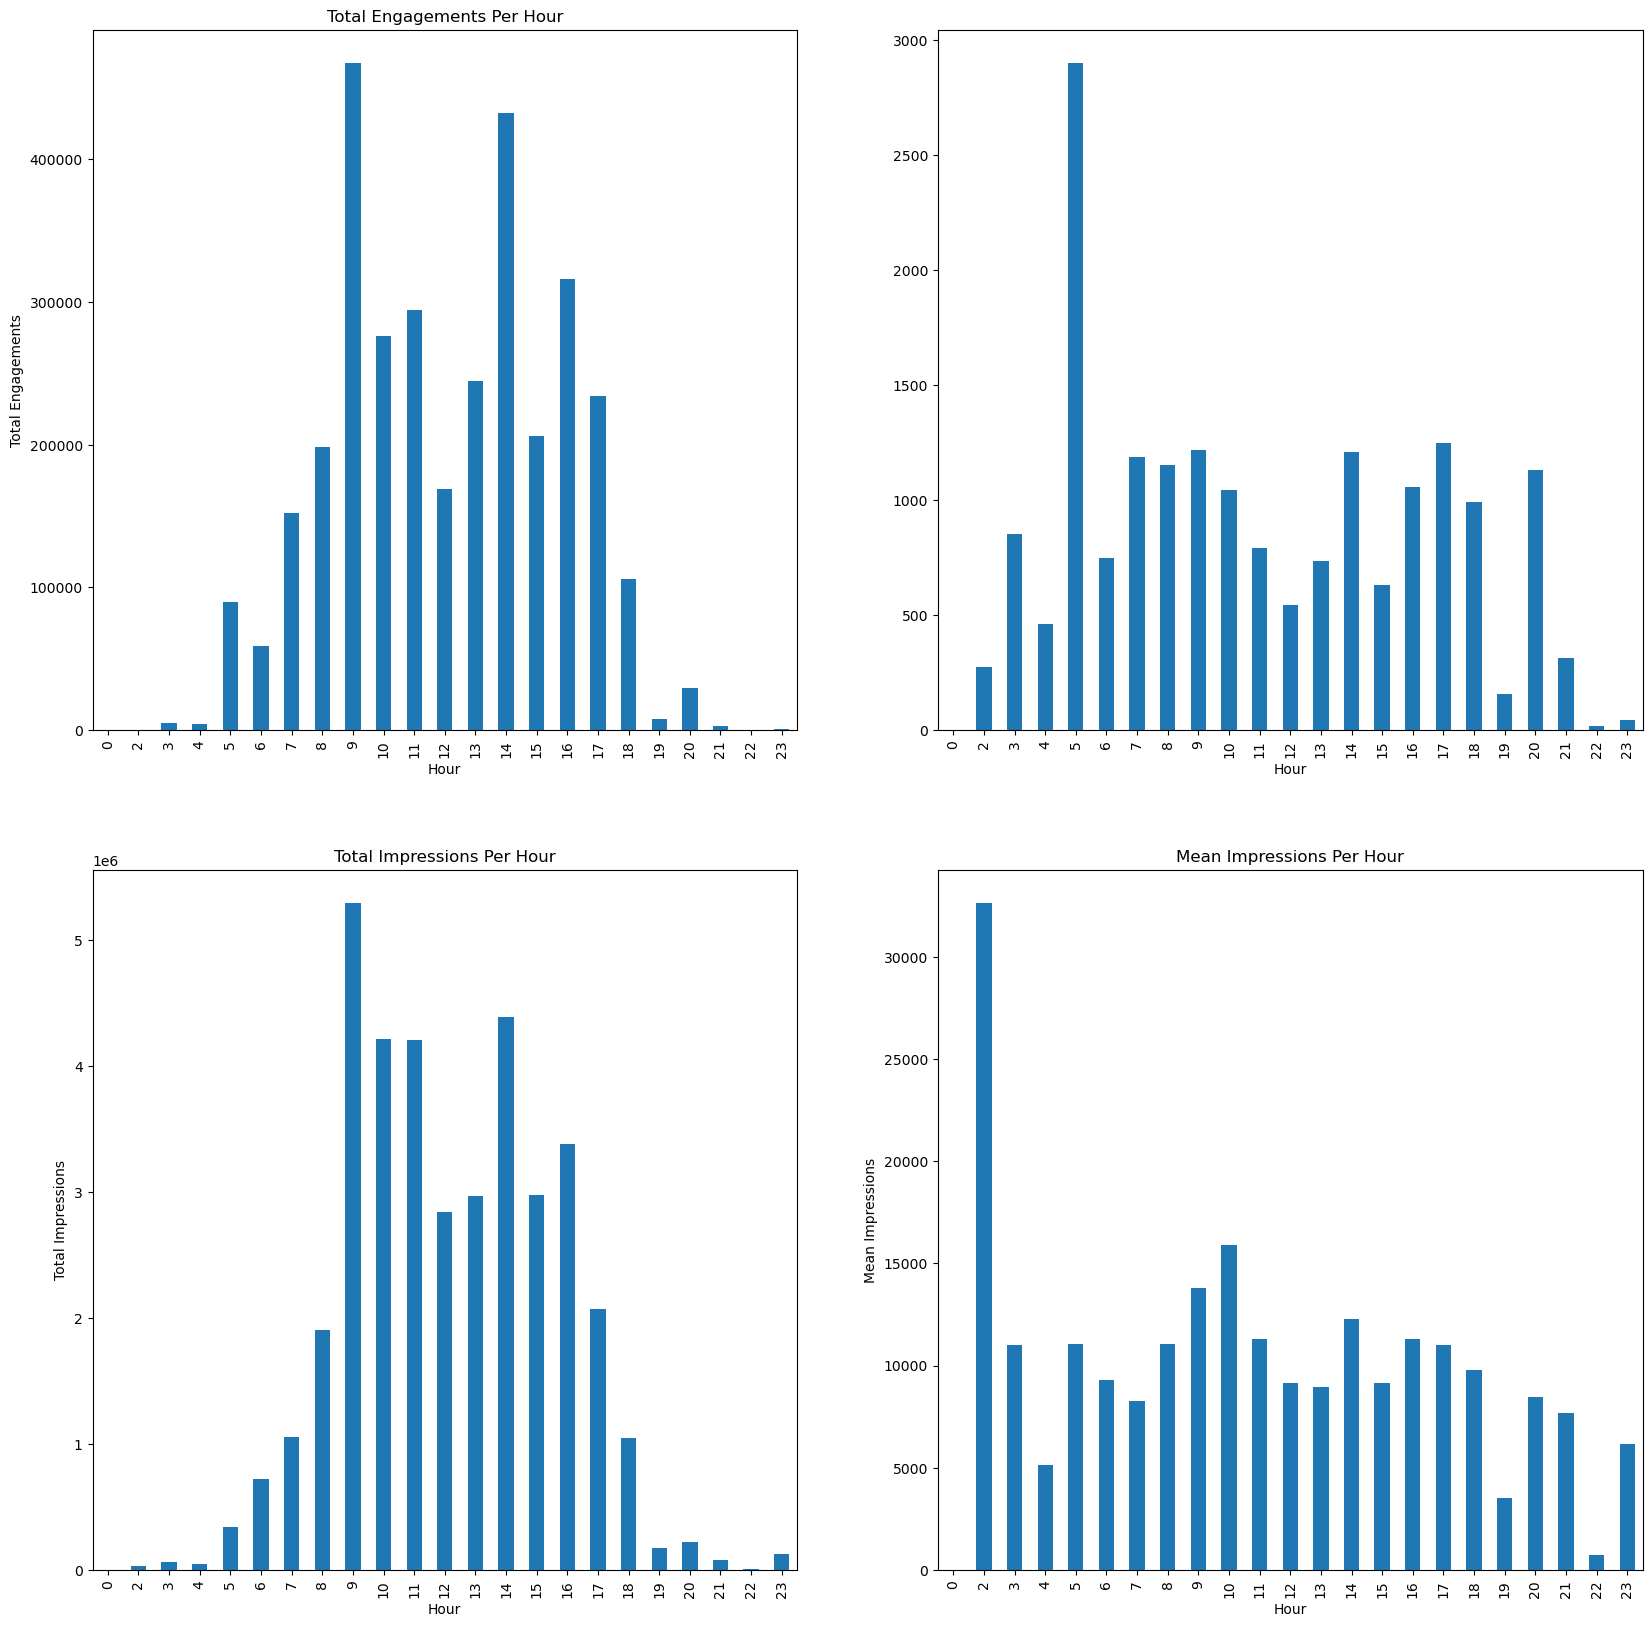

In [33]:
# plot bar graphs to see if hour of post date affects engagement rates
create_imp_eng_fig(hour_engagements_total, hour_engagements_mean, "Hour")

The above bar graphs show the hour in relation to total engagements and impressions. Some things to note are:
- strangely enough, we see a lot of engagement between 5 and 6AM; taking into account the number of posts made at this time (31), we can disregard it (since it's such a low number)
- the range we should really be interested with is the hours 7-18 (7AM to 6PM); this is the range in which the msot posts are made
- engagement in this range does not seem to vary too much (as shown by the smaller variability in the top right bar chart)
- if we want to reach the most people, we should stray away from posting at 12PM and the AMs; instead, we should focus on posting in the late morning (9AM-11AM) and afternoon (2PM-5PM), since this is where we see the most impressions (as shown in the bottom left and right graphs) 

Let us look at engagement ratio per hour

[Text(0.5, 1.0, 'Engagement Ratio Per Hour'),
 Text(0.5, 0, 'Hour'),
 Text(0, 0.5, 'Engagement Rate (%)')]

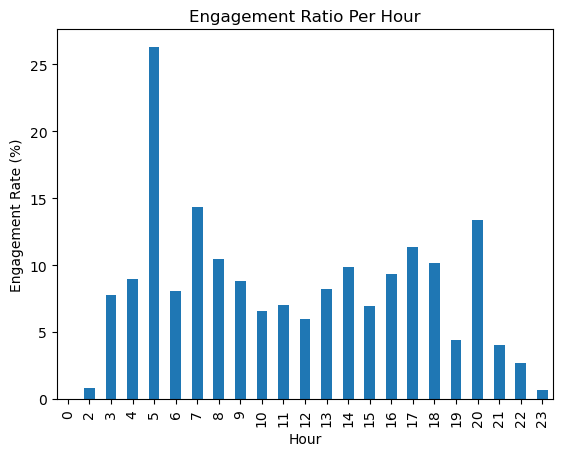

In [34]:
# plot engagement ratio
hour_engagement_rate.plot.bar().set(title = "Engagement Ratio Per Hour",
                                    xlabel = "Hour",
                                    ylabel = "Engagement Rate (%)")

Again, we should mostly disregard most of the AM hours (0-6), since we do not have many posts in that time frame to standardize the data. Furthermore, since most people are asleep during the AM times, it would not make sense to post during these times anyway. 

One interesting thing to note is that engagement rate starts off quite well at around 8AM. However, engagement rates decrease as time continues towards noon (12PM). After noon, however, engagement rate goes up once more. This was seen in the figure above as well. This may be for a variety of reasons, such as most people eat lunch at 12 and, thus, are socializing at work/school instead of looking at social media during this time. 

Around 5PM seems like a great time to post as well. Although any time after 5PM goes towards a downward trend, we see a peak at this time (albeit small). It would make sense to post at around 4PM or even 3:30PM in order to grab attention and increase engagement rate.

To answer the question of whether or not the hour of the posting date seems to affect engagement rate: I would say no. Engagement rate is not affected by the hour of the posting date. Although there is some variability, the jumps are not huge and they seem to follow a pattern of high -> low -> high quite nicely.

Again, using only graphs to make informed decisions is not the best. We should perform ANOVA once more. In this case, the null and alternate hypotheses are:
- H<sub>0</sub> = sample means for each hour is the same
- H<sub>a</sub> = sample means for each hour is not the same

In [35]:
hour_lm, hour_anova = do_anova(df, "Hour")

In [36]:
hour_lm

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Engagement_Rate   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.02732
Date:                Mon, 29 May 2023   Prob (F-statistic):              0.869
Time:                        15:18:34   Log-Likelihood:                -30590.
No. Observations:                3479   AIC:                         6.118e+04
Df Residuals:                    3477   BIC:                         6.120e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     47.8615    100.666      0.475      0.634    -149.509     245.233
Hour          -1.2889      7.798     -0.165      0.869     -16.578      14.000
==============================================================================
Omnibus:                    11687.817   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1749462058.195
Skew:                          58.932   Prob(JB):                         0.00
Kurtosis:                    3475.007   Cond. No.                         48.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notice how the P-value is greater than 0.05. Thus, this is not a statistically significant result. We fail to reject the null hypothesis (all sample means are the same).

In [37]:
hour_anova

,sum_sq,df,F,PR(>F)
Hour,6.942280e+04,1.0,0.027321,0.868724
Residual,8.834983e+09,3477.0,NaN,NaN


Our f-statistic is around 0.03, which is greatly below 1. This means the variation between hours is low. Coupled with the fact that the the p-value of hours in our linear model is greater than 0.05 (and thus we fail to reject the null), we have reason to believe that the variance between hours is quite low.

As such, since the variance between hours in affect engagement rates is low, we can infer that posting at 8AM is not very different from posting at 9AM and posting at 9AM is not very different from 10AM (and so on). However, we do have to take into account that the anova's p-value is above 0.05, so this f-statistic may not be conclusive.

## Number 3: How are our game titles doing in terms of social performance? Is there a specific game we should focus more on or less?

In [38]:
df.Account.unique()

array(['CSGO', 'General ', 'DOTA2', 'Content Creators', 'Valorant',
       'General'], dtype=object)

Notice the two "General" accounts. Why do we have these?

In [39]:
# determine why we have two "General" accounts
df[df["Account"] == "General "]["Account Type"].unique()

array(['FBPAGE', 'TWITTER', 'INSTAGRAM', 'TIKTOK_BUSINESS', 'YOUTUBE'],
      dtype=object)

In [40]:
# determine why we have two "General" accounts
df[df["Account"] == "General"]["Account Type"].unique()

array(['LINKEDIN_COMPANY'], dtype=object)

In [41]:
df.replace("General", 
           "General (LinkedIn)", 
           inplace=True)

In [42]:
df["Account"].unique()

array(['CSGO', 'General ', 'DOTA2', 'Content Creators', 'Valorant',
       'General (LinkedIn)'], dtype=object)

It turns out that the "General" account without a space contains information for the LinkedIn account. The "General" account with a space contains information for the other general accounts. Although we can combine them together (since they're both general accounts), I want to keep them separate because LinkedIn is a very different social media account than Twitter or Instagram. One is mostly for leisure ("General" with a space), the other is for networking ("General" without a space (LinkedIn)). Therefore, I will keep them separate.

In [43]:
# create game title data frames to determine how the game titles are doing and which game should be focused on more or less
gt_engagements_total, gt_engagements_mean, gt_engagement_rate = create_total_mean_df(df, "Account")

C:\Users\Florence.000\AppData\Local\Temp\ipykernel_796\930955517.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_total = df.groupby(column_to_gb).sum().drop(columns = ["Hour"])
C:\Users\Florence.000\AppData\Local\Temp\ipykernel_796\930955517.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df.groupby(column_to_gb).mean().drop(columns = ["Hour"])


In [44]:
gt_engagements_total

,Total Impressions,Total Engagements
Account,,
CSGO,2313918,92336
Content Creators,45186,1387
DOTA2,1859326,123990
General,33888956,3076479
General (LinkedIn),42801,849
Valorant,22979,931


In [45]:
gt_engagements_mean

,Total Impressions,Total Engagements
Account,,
CSGO,8570.066667,341.985185
Content Creators,852.566038,26.169811
DOTA2,2315.474471,154.408468
General,14922.481726,1354.680317
General (LinkedIn),1945.500000,38.590909
Valorant,382.983333,15.516667


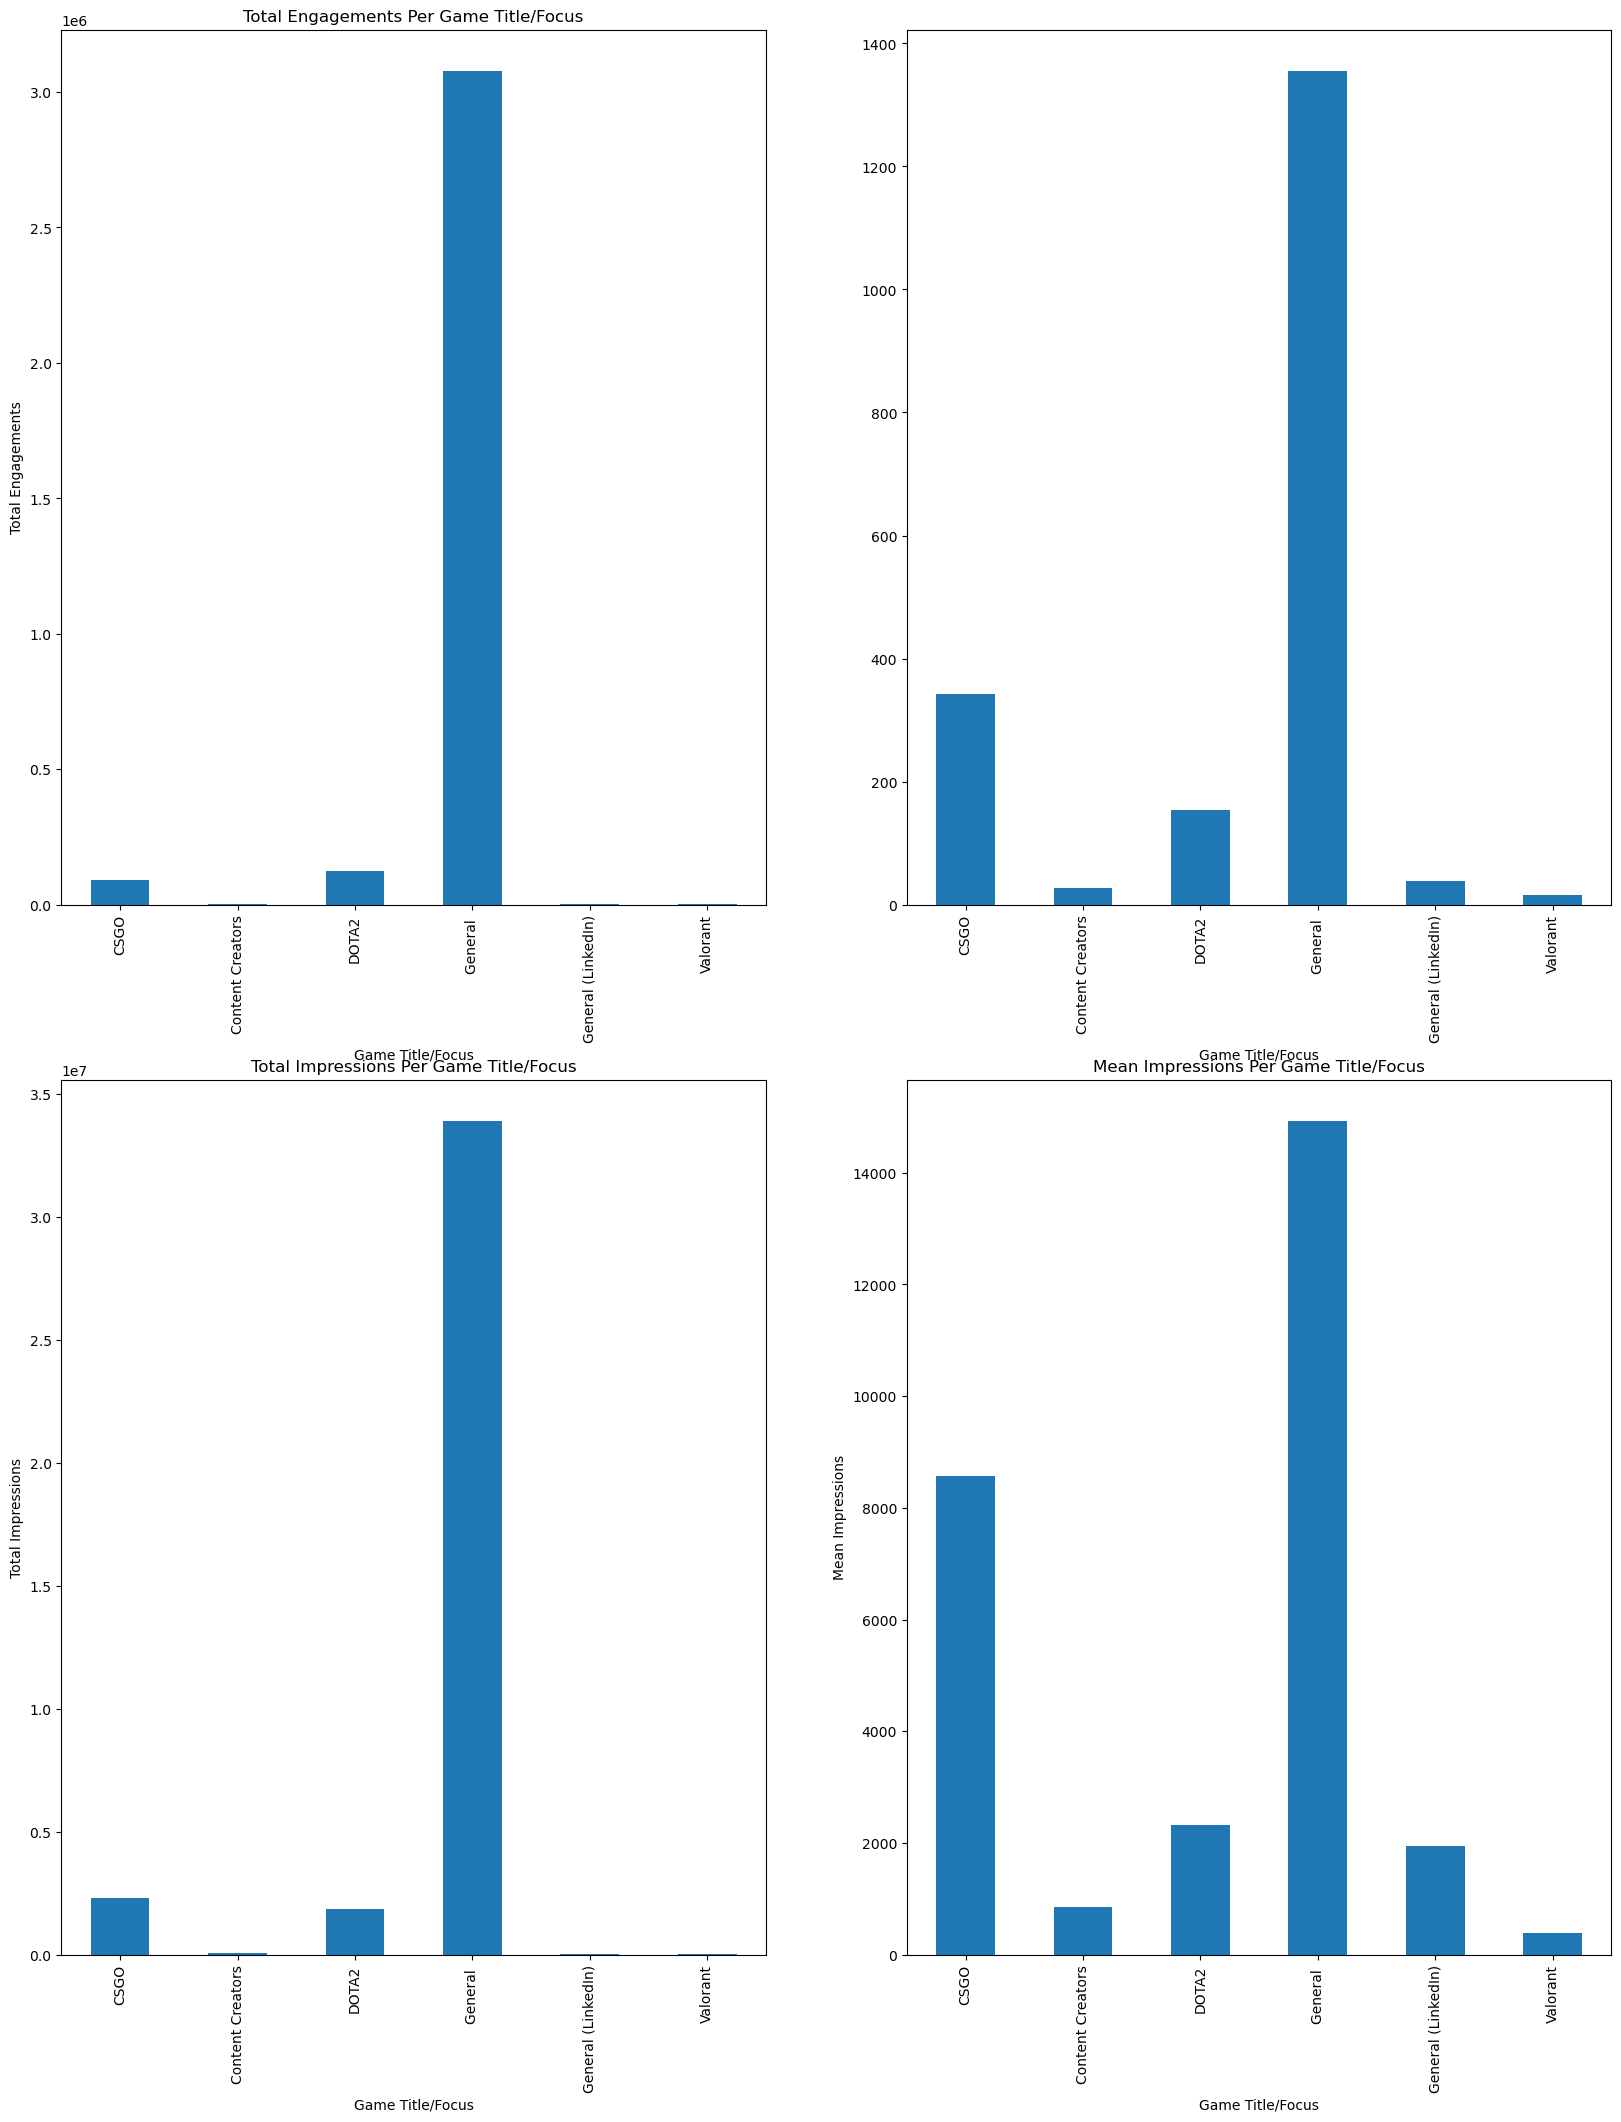

In [46]:
# plot bar graphs to see game title social performance
create_imp_eng_fig(gt_engagements_total, gt_engagements_mean, "Game Title/Focus", figsize = (20, 25))

If we are strictly talking about games in this data set (CSGO, Dota2 and Valorant), Valorant is the least popular esports team EG has. The EG general (non-LinkedIn) accounts have the most engagements, however. This makes sense, since it is followed by the most people and covers all of EG's games (including the games and posts not categorized in this data set, such as League of Legends).

[Text(0.5, 1.0, 'Engagement Rate Per Game Title'),
 Text(0.5, 0, 'Game Title/Focus'),
 Text(0, 0.5, 'Engagement Rate (%)')]

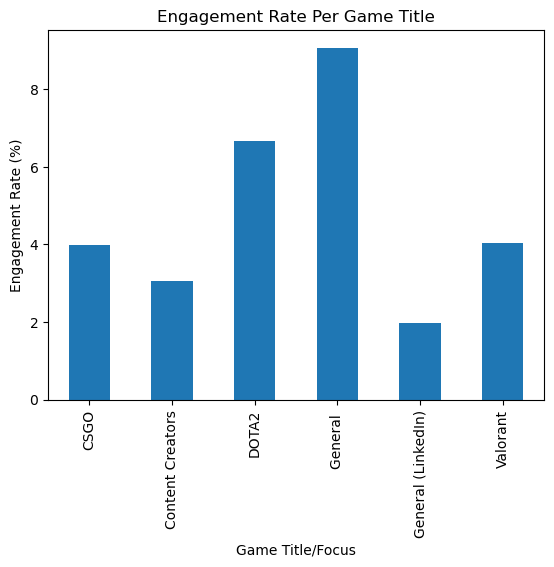

In [47]:
# plot engagement ratio
gt_engagement_rate.plot.bar().set(title = "Engagement Rate Per Game Title",
                                  xlabel = "Game Title/Focus",
                                  ylabel = "Engagement Rate (%)")

With more context of engagement rate, it is clear that the game titles we have are not doing too bad. If we define "Good engagement rate" by 5%, only DOTA2 and the general account meets this standard. The game we should focus on more is Valorant. If we are talking about all social media accounts, we should be focusing the most on our content creator accounts.

We should make a disctinction on the account type as well in order to make a more informed decision.

In [48]:
# create game title data frames specific to the account types since not all social media account is created equal
gt2_engagements_total, gt2_engagements_mean, gt2_engagement_rate = create_total_mean_df(df, ["Account", "Account Type"])

C:\Users\Florence.000\AppData\Local\Temp\ipykernel_796\930955517.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_total = df.groupby(column_to_gb).sum().drop(columns = ["Hour"])
C:\Users\Florence.000\AppData\Local\Temp\ipykernel_796\930955517.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df.groupby(column_to_gb).mean().drop(columns = ["Hour"])


In [49]:
gt2_engagements_total

Total Impressions  Total Engagements
Account            Account Type                                          
CSGO               TWITTER                     2313918              92336
Content Creators   YOUTUBE                       45186               1387
DOTA2              TWITTER                     1790811             119389
                   YOUTUBE                       68515               4601
General            FBPAGE                     14473148            2577284
                   INSTAGRAM                   3574059              84087
                   TIKTOK_BUSINESS              344159              18865
                   TWITTER                    15395867             392834
                   YOUTUBE                      101723               3409
General (LinkedIn) LINKEDIN_COMPANY              42801                849
Valorant           YOUTUBE                       22979                931

In [50]:
gt2_engagements_mean

Total Impressions  Total Engagements
Account            Account Type                                          
CSGO               TWITTER                 8570.066667         341.985185
Content Creators   YOUTUBE                  852.566038          26.169811
DOTA2              TWITTER                 2252.592453         150.174843
                   YOUTUBE                 8564.375000         575.125000
General            FBPAGE                 24740.423932        4405.613675
                   INSTAGRAM               6078.331633         143.005102
                   TIKTOK_BUSINESS         3045.654867         166.946903
                   TWITTER                17376.825056         443.379233
                   YOUTUBE                 1027.505051          34.434343
General (LinkedIn) LINKEDIN_COMPANY        1945.500000          38.590909
Valorant           YOUTUBE                  382.983333          15.516667

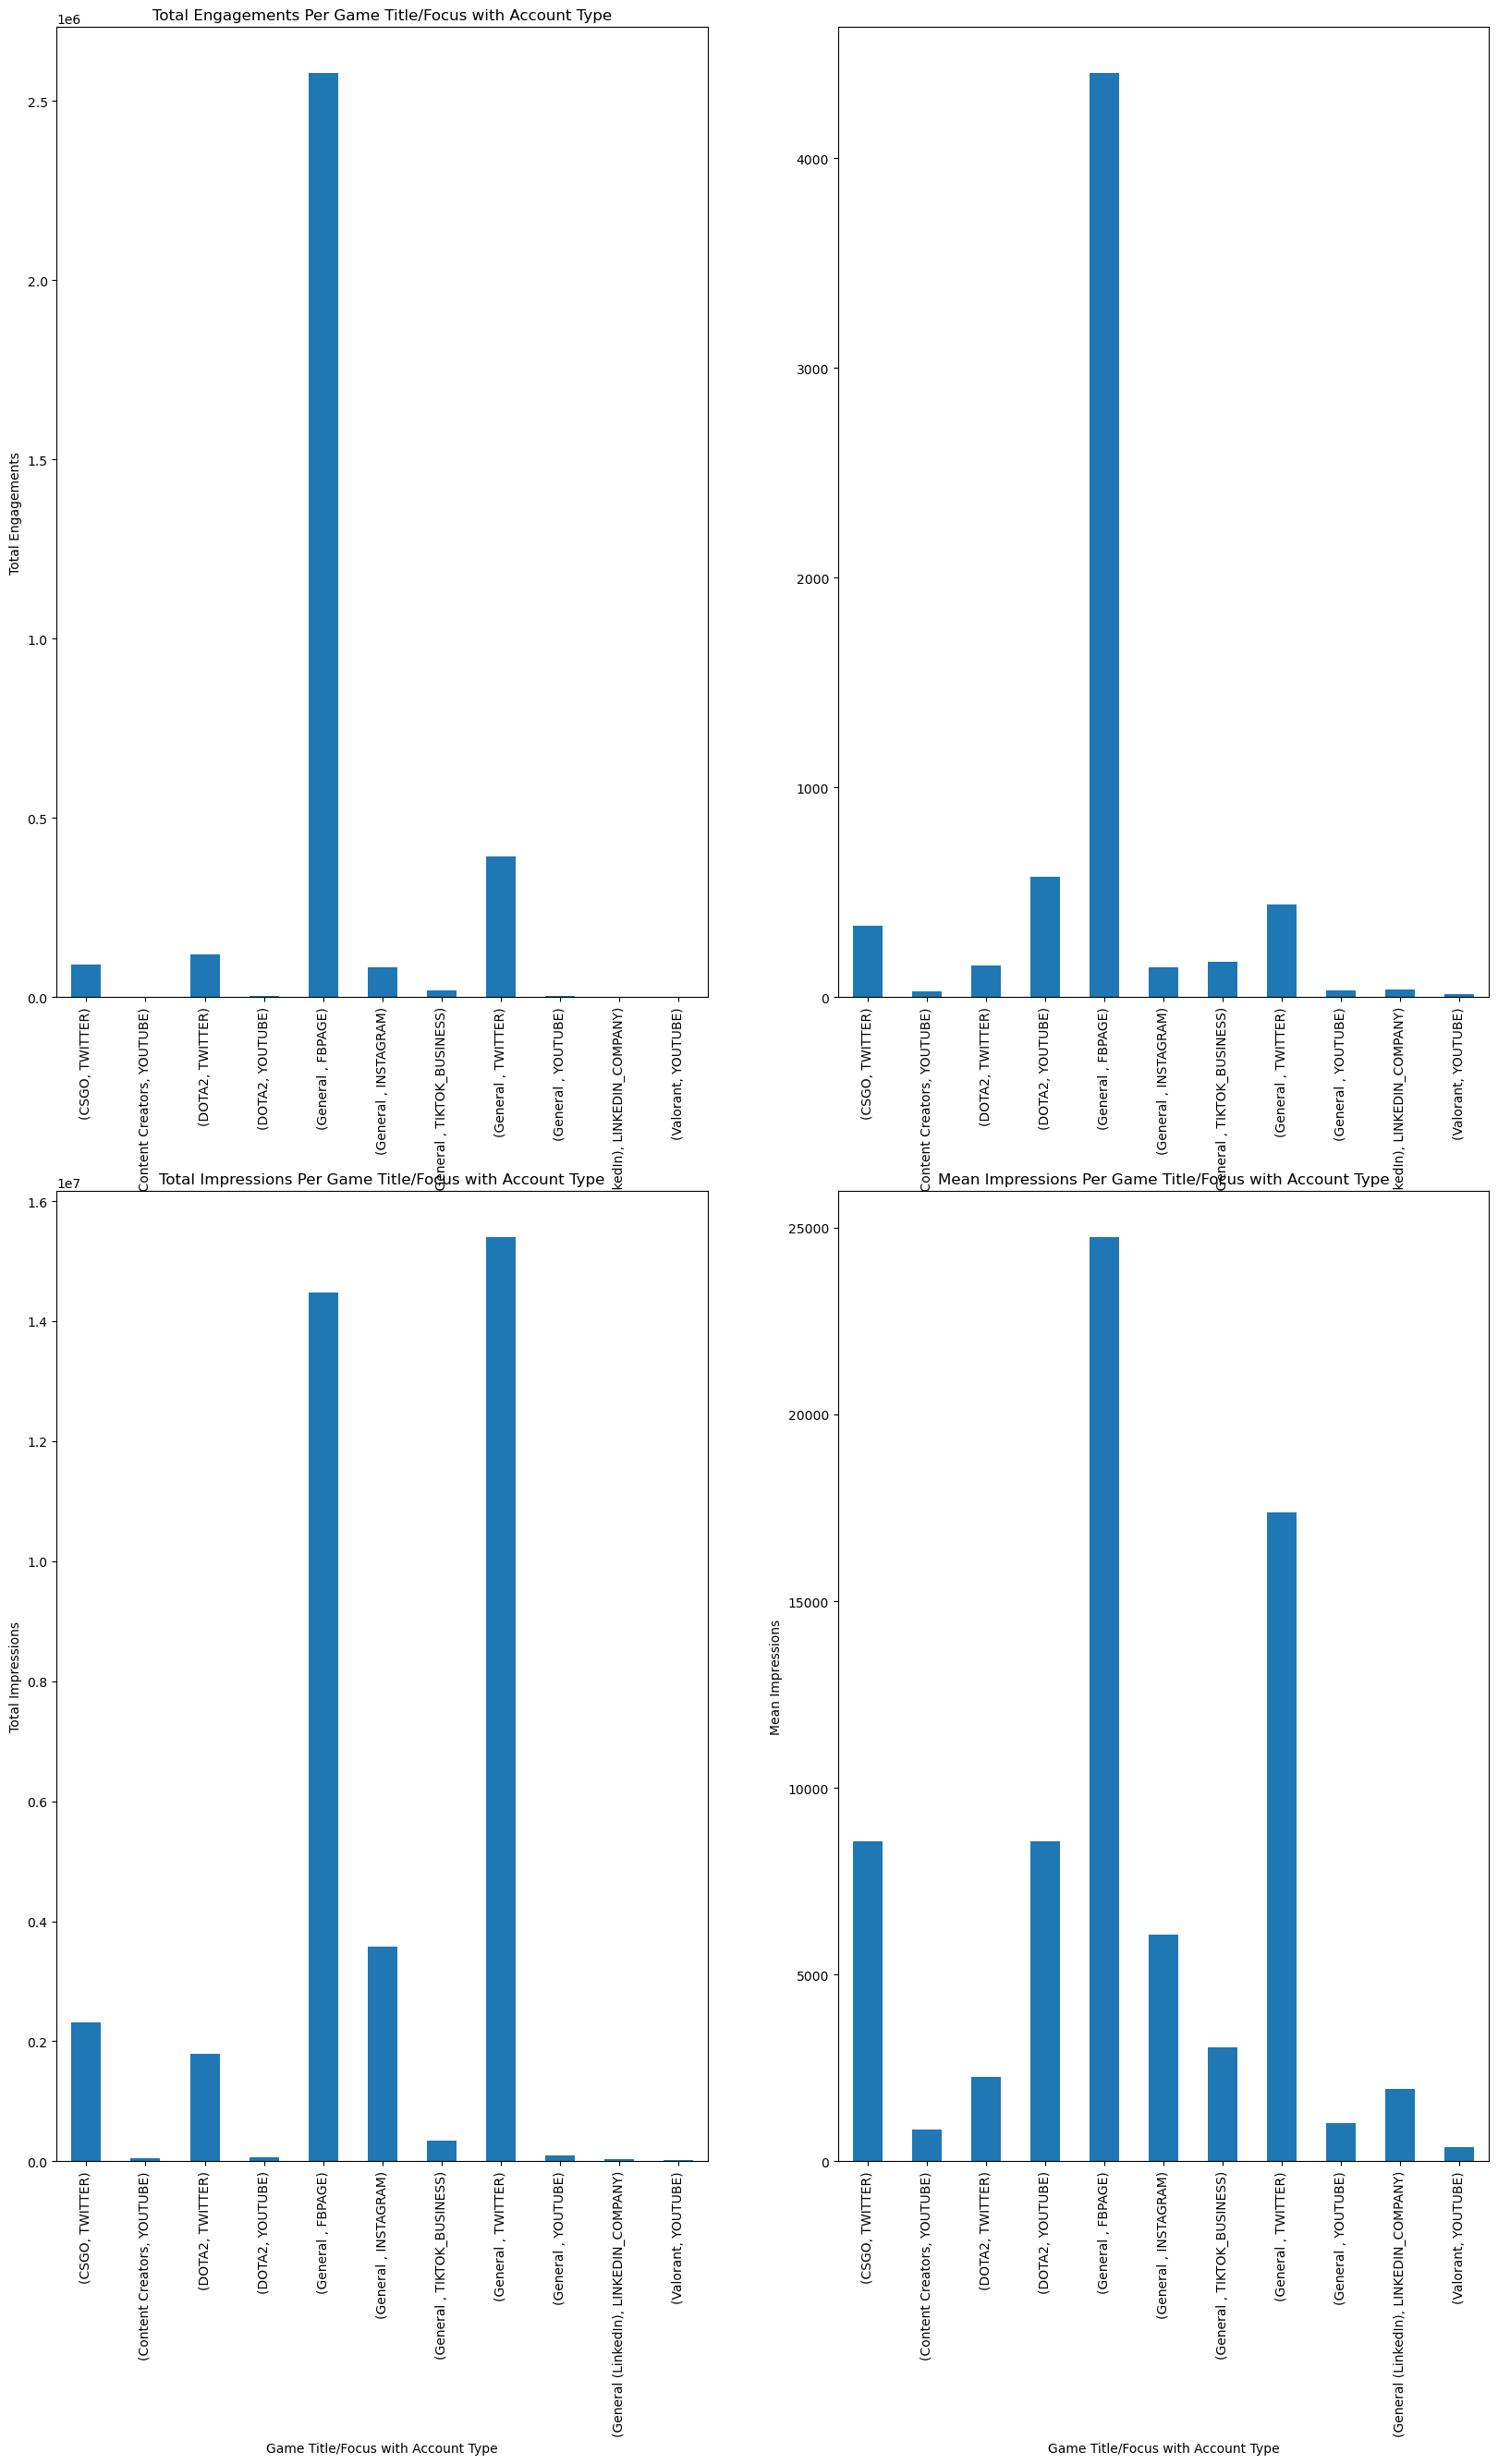

In [51]:
# plot bar graphs to see game title social performance
create_imp_eng_fig(gt2_engagements_total, gt2_engagements_mean, "Game Title/Focus with Account Type", figsize = (20, 30))

As shown above, it is clear that Facebook and Twitter have the highest engagement and impressions. This comes at a surprise, due to the stigma around Facebook and its older userbase. How are the engagement rates?

[Text(0.5, 1.0, 'Engagement Rate Per Game Title/Focus with Account Type'),
 Text(0.5, 0, 'Game Title/Focus'),
 Text(0, 0.5, 'Engagement Rate')]

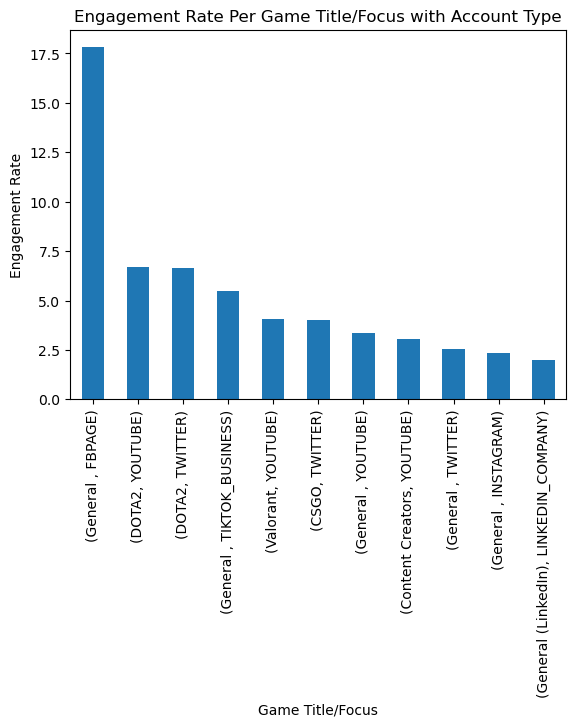

In [52]:
# plot engagement ratio
gt2_engagement_rate.sort_values(ascending = False).plot.bar().set(title = "Engagement Rate Per Game Title/Focus with Account Type",
                                                                  xlabel = "Game Title/Focus",
                                                                  ylabel = "Engagement Rate")

Consistent with the 4 bar graphs of total and mean engagements and impressions, this engagement rate bar graph shows that the FB Page does the best. Surprisingly, DOTA2 has the highest engagement rate. If we want to reach the most people to talk about general EG news, we should use the Facebook Page. If are strictly talking about game titles, DOTA2 seems to do the best (as seen by the fact that DOTA2 YouTube and Twitter accounts are top 3).

All in all, our game titles are doing fine in terms of social performance. Although they can do better, if we are do define a "good" engagement rate by 5%, Valorant and CSGO are close and DOTA2 is above that engagement rate. The game we should focus on more is CS:GO. This is for a variety of reasons, such as the fact that CS:GO was the second most watched [Esport in 2022](https://escharts.com/news/most-watched-esports-games-2022) behind League of Legends. However, since most of the League of Legends news is in the General column (which is doing very well), we can afford to focus a bit less on it in order to improve our CS:GO metrics.

# Number 4: WHAT MEDIA TYPE PERFORMS THE BEST

In [53]:
df["Media Type"].unique()

array(['Text', 'Video', 'Photo', 'Link', 'Carousel', 'Mixed', 'Album'],
      dtype=object)

In [54]:
# make sure we have sufficient amount of different types of media posts
df.groupby("Media Type").count().iloc[:, 0]

Media Type
Album          4
Carousel       9
Link          94
Mixed          5
Photo       1490
Text         910
Video        967
Name: Published Date, dtype: int64

In [55]:
# create media data frames to see if media type affects engagement rates
media_engagements_total, media_engagements_mean, media_engagement_rate = create_total_mean_df(df, "Media Type")

C:\Users\Florence.000\AppData\Local\Temp\ipykernel_796\930955517.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_total = df.groupby(column_to_gb).sum().drop(columns = ["Hour"])
C:\Users\Florence.000\AppData\Local\Temp\ipykernel_796\930955517.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df.groupby(column_to_gb).mean().drop(columns = ["Hour"])


In [56]:
media_engagements_total

,Total Impressions,Total Engagements
Media Type,,
Album,20,8
Carousel,160689,6541
Link,232465,2257
Mixed,184984,13664
Photo,23893992,2167739
Text,3106203,246312
Video,10594813,859451


In [57]:
media_engagements_mean

,Total Impressions,Total Engagements
Media Type,,
Album,5.000000,2.000000
Carousel,17854.333333,726.777778
Link,2473.031915,24.010638
Mixed,36996.800000,2732.800000
Photo,16036.236242,1454.858389
Text,3413.409890,270.672527
Video,10956.373320,888.780765


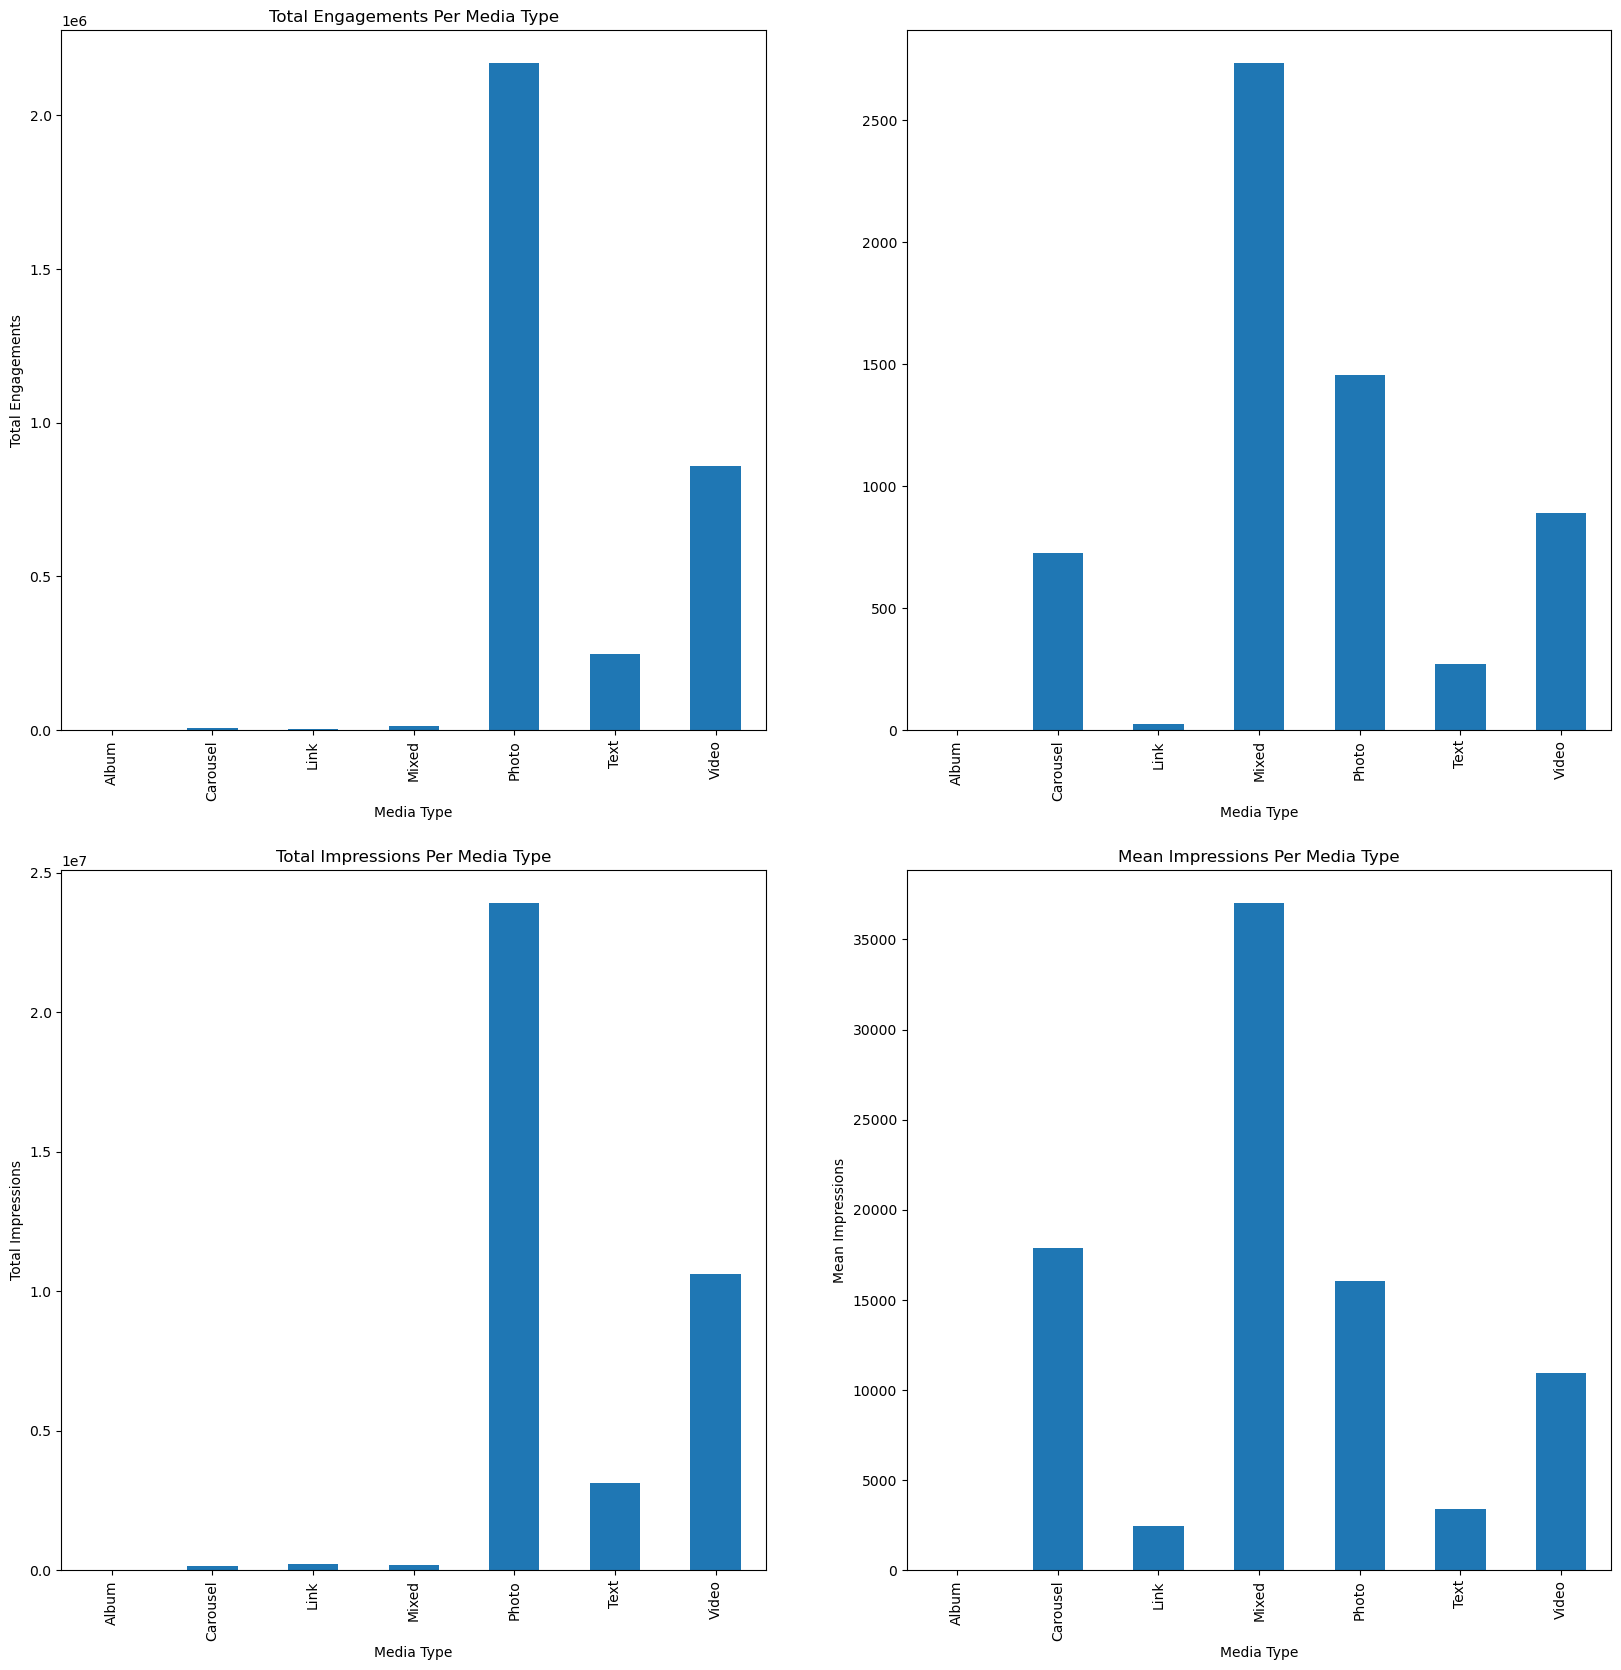

In [58]:
# plot bar graphs to assess which media type performs the best
create_imp_eng_fig(media_engagements_total, media_engagements_mean, "Media Type")

The media type that seems to perform the best is the "Mixed" category. However, I am a big skeptical, due to the low number of mixed posts (5). Instead of focusing on these graphs, we should be more conscious about the count.

In [59]:
# create data frame with engagement ratio and count of each media type
media_engagementrate_count = pd.concat([media_engagement_rate.rename("Engagement Rate"), df.groupby("Media Type").count().iloc[:, 0].rename("Count")], axis = 1)
media_engagementrate_count

,Engagement Rate,Count
Media Type,,
Album,40.000000,4
Carousel,4.070596,9
Link,0.970899,94
Mixed,7.386585,5
Photo,9.072318,1490
Text,7.929681,910
Video,8.111998,967


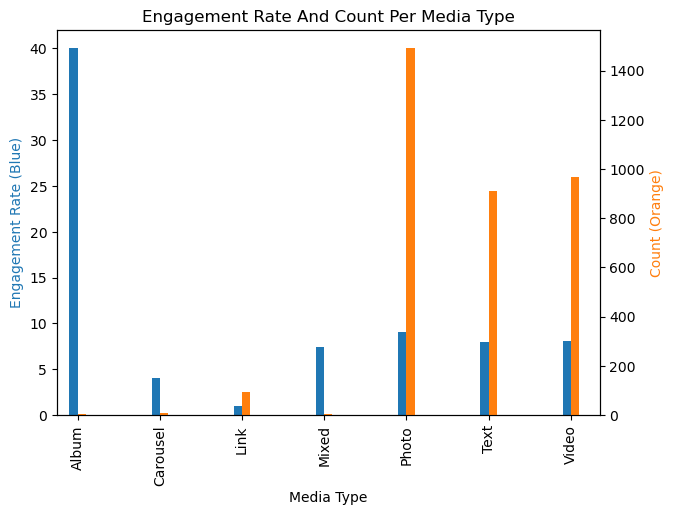

In [60]:
# plot engagement ratio and count

fig, ax1 = plt.subplots(figsize = (7, 5))


ax2 = ax1.twinx()

media_engagementrate_count["Engagement Rate"].plot(kind = "bar", ax = ax1, color = "tab:blue", width = 0.1, position = 1)
media_engagementrate_count["Count"].plot(kind = "bar", ax = ax2, color = "tab:orange", width = 0.1, position = 0)

ax1.set_xlabel("Media Type")
ax1.set_ylabel("Engagement Rate (Blue)", color = "tab:blue")
ax2.set_ylabel("Count (Orange)", color = "tab:orange")

ax1.set_title("Engagement Rate And Count Per Media Type")

plt.show()

This chart shows the engagement rate on the left (as blue) and the number of posts of that type (as orance). Links seem to be the worst performing media type, as it has the worst engagement rate. Although its count is low, it is still higher than album, carousel, and mixed posts, which suggests that links may be the worst type of post. On the other hand photos are possibly the best media type. Notice how we have many photo posts with an engagement rate of around 10%. Albums may also be quite good, but since its count is so terribly low, I am hesitant to say that it is the best media type. If EG wants to focus on engagement rates through media types, photos are the best.

# Number 5: WHAT IS OUR BEST PERFORMING CAMPAIGN

In [61]:
df["Campaign Name"].unique()

array(['N/A ', 'Community Engagement ', 'Evergreen ', 'Evil Exhibited '],
      dtype=object)

In [62]:
# create campaign data frames assess best performing campaign
campaign_engagements_total, campaign_engagements_mean, campaign_engagement_rate = create_total_mean_df(df, "Campaign Name")

C:\Users\Florence.000\AppData\Local\Temp\ipykernel_796\930955517.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_total = df.groupby(column_to_gb).sum().drop(columns = ["Hour"])
C:\Users\Florence.000\AppData\Local\Temp\ipykernel_796\930955517.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df.groupby(column_to_gb).mean().drop(columns = ["Hour"])


In [63]:
campaign_engagements_total

,Total Impressions,Total Engagements
Campaign Name,,
Community Engagement,23803756,2044767
Evergreen,1328729,43127
Evil Exhibited,5742595,185305
N/A,7298086,1022773


In [64]:
campaign_engagements_mean

,Total Impressions,Total Engagements
Campaign Name,,
Community Engagement,16870.131821,1449.161588
Evergreen,8151.711656,264.582822
Evil Exhibited,13672.845238,441.202381
N/A,4914.536027,688.736027


In [65]:
# create data frame with engagement ratio and count of each campaign
campaign_engagementrate_count = pd.concat([campaign_engagement_rate.rename("Engagement Rate"), df.groupby("Campaign Name").count().iloc[:, 0].rename("Count")], axis = 1)
campaign_engagementrate_count

,Engagement Rate,Count
Campaign Name,,
Community Engagement,8.590102,1411
Evergreen,3.245733,163
Evil Exhibited,3.226851,420
N/A,14.014263,1485


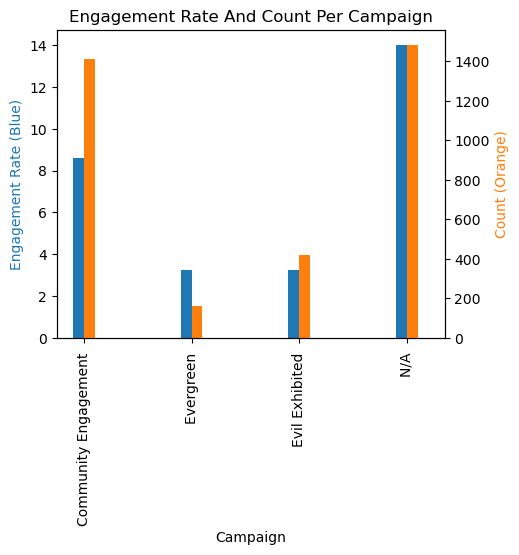

In [66]:
fig, ax1 = plt.subplots(figsize = (5, 4))


ax2 = ax1.twinx()

campaign_engagementrate_count["Engagement Rate"].plot(kind = "bar", ax = ax1, color = "tab:blue", width = 0.1, position = 1)
campaign_engagementrate_count["Count"].plot(kind = "bar", ax = ax2, color = "tab:orange", width = 0.1, position = 0)

ax1.set_xlabel("Campaign")
ax1.set_ylabel("Engagement Rate (Blue)", color = "tab:blue")
ax2.set_ylabel("Count (Orange)", color = "tab:orange")

ax1.set_title("Engagement Rate And Count Per Campaign")

plt.show()

The best performing campaign is Community Engagement. N/A campaigns probably include campaigns that have no campaign type and, thus, cannot be categorized. Thus, I will disregard its (extemely positive) performance. Instead, focusing on the other three campaigns, it is clear that community engagement performs the best. It has the highest engagement rate and is done the most.

## Number 6: Define out a posting strategy for our social channels based on your discoveries.

From what I have discovered, the best posting strategy would be as so:
1. Determine which account we are posting on. 
- Are we trying to reach as many people as possible for perhaps a sponsor? Post this on the EG General Accounts (Facebook being the most important)
- Are we trying to reach a specific audience such as our CS:GO audience? Our DOTA audience? Post it on those specific accounts.
2. Determine the reach of the post.
- Are we talking to fans specific to a game? Post on that specific account.
- Are we talking to fans of EG? To reach the most EG fans, we should post on our FB General page or Twitter General Page.
- Are we talking to esports fans? To reach the most esports fans, we should post on our FB General pageor Twitter General Page.
3. Determine the goal of the post
- Is it serious (like the resignation of player(s) in a certain game)? A combination of text and a photo can be serviceable. It is even better if there is a video attached to it explaining the resignation.
- Is it to gain more fans? Albums generate the most engagement; as such, albums can be a good way of generating clicks and, thus, more fans. Community engagement campaigns have the highest engagement rate; as such, this is the best type of campaigh.
3. Time
- The best time to post is always in the mornings and afternoon. Do not post at 12 and do not past past 10PM.

## Number 7: What suggestions would you give to the social media team if they want to expand their presence (e.g. if our CSGO youtube channel is doing well should we expand to TikTok)?

One suggestion I would give to the social media team if they want to expand their presence is to focus posting photos. Photos have the highest total impressions. They are easy to see and, as long as the photo is eye-catching enough (creating an eye-catching photo is another story), photos have the largest reach. 

Another suggestion I have is that videos do quite well. DOTA2's (the best performing game out of Valorant, CSGO, and DOTA2) best performing account type is their YouTube. Close behind is their TikTok. Therefore, it would be a good idea to expand to more short form video such as the videos on TikTok.

Another suggestion I would give to the social media team is to only post during 8AM-11AM and 2PM-5PM. These are the time ranges where we see an upward trend of engagement and impressions. Even though in the ANOVA test we failed to reject the null, there is a small trend that I see that I cannot ignore.

Another suggestion I would have is to not worry too much about campaigns. the N/A category of campaigns did the best; therefore, it isn't a stretch to say that campaigns aren't a big reason as to how EG gets its fans.